In [1]:
#Import all the libraries need for the analysis

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import BallTree
from datetime import datetime
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


In [2]:
#loading data through path
DATA_PATH = 'C:\Kwara_State_Project'  
ORIG_CSV = os.path.join(DATA_PATH, "C:\Kwara_State_Project\Kwara_crosschecked2.csv")
ENRICHED_CSV = os.path.join(DATA_PATH, "C:\Kwara_State_Project\Kwara_outliers.csv")
EXCEL_OUT = os.path.join(DATA_PATH, "C:\Kwara_State_Project\Kwara_outliers_sorted.xlsx")
TOP3_CSV = os.path.join(DATA_PATH, "C:\Kwara_State_Project\Kwara_top3_overall.csv")
PLOTS_DIR = os.path.join(DATA_PATH, 'plots')

# Create the plots folder if it doesn't exist
os.makedirs(PLOTS_DIR, exist_ok=True)



In [3]:
# Print paths to confirm
print("DATA_PATH =", DATA_PATH)
print("Original CSV expected at:", ORIG_CSV)
print("Plots will be saved to:", PLOTS_DIR)

DATA_PATH = C:\Kwara_State_Project
Original CSV expected at: C:\Kwara_State_Project\Kwara_crosschecked2.csv
Plots will be saved to: C:\Kwara_State_Project\plots


In [4]:
# Inspect Dataset
df_raw = pd.read_csv(ORIG_CSV)
print('Rows, Columns:', df_raw.shape)
print('\nColumns:')
print(df_raw.columns.tolist())

df_raw.head()

Rows, Columns: (2518, 21)

Columns:
['State', 'LGA', 'Ward', 'PU-Code', 'PU-Name', 'Latitude', 'Longitude', 'Accredited_Voters', 'Registered_Voters', 'Results_Found', 'Transcription_Count', 'Result_Sheet_Stamped', 'Result_Sheet_Corrected', 'Result_Sheet_Invalid', 'Result_Sheet_Unclear', 'Result_Sheet_Unsigned', 'APC', 'LP', 'PDP', 'NNPP', 'Results_File']


,State,LGA,Ward,PU-Code,PU-Name,Latitude,Longitude,Accredited_Voters,Registered_Voters,Results_Found,...,Result_Sheet_Stamped,Result_Sheet_Corrected,Result_Sheet_Invalid,Result_Sheet_Unclear,Result_Sheet_Unsigned,APC,LP,PDP,NNPP,Results_File
0,KWARA,ASA,YOWERE/SOSOKI,23-01-01-002,ONIYEYE OPEN SPACE,8.821483,4.053179,220,750,True,...,False,False,False,False,UNKNOWN,106,0,109,0,https://docs.inecelectionresults.net/elections...
1,KWARA,ASA,YOWERE/SOSOKI,23-01-01-003,LAODU 1 OPEN SPACE,38.297131,-85.563099,235,786,True,...,False,False,False,False,UNKNOWN,135,0,81,1,https://docs.inecelectionresults.net/elections...
2,KWARA,ASA,YOWERE/SOSOKI,23-01-01-004,IDI-OSE L.G.E.A SCH,7.452140,4.060890,250,876,True,...,False,True,False,False,UNKNOWN,116,0,99,0,https://docs.inecelectionresults.net/elections...
3,KWARA,ASA,ELEBUE/AGBONA/FATA,23-01-03-001,OJA-IYA L.G.E.A SCH,8.482029,4.548098,215,647,True,...,False,False,False,False,UNKNOWN,99,0,101,0,https://docs.inecelectionresults.net/elections...
4,KWARA,ASA,ELEBUE/AGBONA/FATA,23-01-03-002,AGBONA L.G.E.A SCH,28.039089,-16.612644,215,600,True,...,False,False,False,False,UNKNOWN,108,0,82,2,https://docs.inecelectionresults.net/elections...


In [5]:
# Identify latitude/longitude columns (common names)
lat_col = next((c for c in df_raw.columns if c.lower() in ('latitude','lat')), None)
lon_col = next((c for c in df_raw.columns if c.lower() in ('longitude','lon','long')), None)
print('\nDetected lat column:', lat_col, 'lon column:', lon_col)


Detected lat column: Latitude lon column: Longitude


In [6]:
# Heuristic party detection (adjust list if needed)
possible_parties = ['APC','PDP','LP','NNPP']
party_cols = [p for p in possible_parties if p in df_raw.columns]

# fallback: numeric short uppercase columns
if not party_cols:
    party_cols = [c for c in df_raw.select_dtypes(include=[np.number]).columns if len(c)<=6 and c.isupper()]

print('\nDetected party columns:', party_cols)


Detected party columns: ['APC', 'PDP', 'LP', 'NNPP']


In [7]:
# Neighbour Identification (1 km)

radius_km = 1.0
earth_km = 6371.0088
radius_rad = radius_km / earth_km

# Ensure lat/lon exist
if lat_col is None or lon_col is None:
    raise ValueError('Latitude or Longitude column not found. Geocode first.')

# Prepare working dataframe (drop rows with missing coords)
df = df_raw.dropna(subset=[lat_col, lon_col]).reset_index(drop=True).copy()
coords_rad = np.radians(df[[lat_col, lon_col]].astype(float).values)

# Build BallTree
btree = BallTree(coords_rad, metric='haversine')
inds_array = btree.query_radius(coords_rad, r=radius_rad, return_distance=False)

# Build neighbor lists excluding self
pu_code_col = next((c for c in df.columns if c.lower() in ('pu-code','pu code','pu_code')), df.columns[0])
neighbor_indices = []
neighbor_counts = []
neighbor_pu_codes = []
for i, inds in enumerate(inds_array):
    inds_no_self = inds[inds != i]
    neighbor_indices.append(inds_no_self.tolist())
    neighbor_counts.append(len(inds_no_self))
    neighbor_pu_codes.append(df.iloc[inds_no_self][pu_code_col].astype(str).tolist())

# Attach to df
df['neighbor_count_1km'] = neighbor_counts
df['neighbor_pu_codes_1km'] = neighbor_pu_codes

print('Neighbour identification complete. Sample neighbor counts:')
print(df['neighbor_count_1km'].describe())

Neighbour identification complete. Sample neighbor counts:
count    2518.000000
mean      268.729150
std       376.453723
min         0.000000
25%         1.000000
50%         7.000000
75%       813.000000
max       813.000000
Name: neighbor_count_1km, dtype: float64


In [8]:
# Outlier Score Calculation

def robust_zscore(value, neigh_vals):
    neigh = np.array(neigh_vals, dtype=float)
    neigh = neigh[~np.isnan(neigh)]
    if neigh.size == 0:
        return (np.nan, np.nan, np.nan)
    mu = neigh.mean()
    sigma = neigh.std(ddof=0)
    if sigma == 0:
        z = value - mu
    else:
        z = (value - mu) / sigma
    return (mu, sigma, z)

In [9]:
# Compute per-party stats
computed_parties = []
for p in party_cols:
    if p not in df.columns:
        print(f'Warning: party column {p} not found - skipping')
        continue
    computed_parties.append(p)
    means = []
    stds = []
    zs = []
    abs_zs = []
    for i in range(len(df)):
        val = df.loc[i, p]
        neigh_idx = neighbor_indices[i]
        neigh_vals = df.loc[neigh_idx, p].to_numpy() if len(neigh_idx) > 0 else np.array([])
        mu, sigma, z = robust_zscore(val, neigh_vals)
        means.append(mu); stds.append(sigma); zs.append(z); abs_zs.append(np.abs(z) if not np.isnan(z) else np.nan)
    df[f'{p}_neigh_mean_1km'] = means
    df[f'{p}_neigh_std_1km'] = stds
    df[f'{p}_zscore_1km'] = zs
    df[f'{p}_abs_zscore_1km'] = abs_zs

In [10]:
# overall score

abs_cols = [f'{p}_abs_zscore_1km' for p in computed_parties]
if abs_cols:
    df['max_abs_z_1km'] = df[abs_cols].max(axis=1, skipna=True)
else:
    df['max_abs_z_1km'] = np.nan


In [11]:
# Create long-format table: one row per (PU, party) with neighbor list and scores
rows = []
for i, row in df.iterrows():
    for p in computed_parties:
        rows.append({
            'PU_Index': i,
            'PU_Code': row.get(pu_code_col, ''),
            'PU_Name': row.get('PU-Name', ''),
            'LGA': row.get('LGA', ''),
            'Ward': row.get('Ward', ''),
            'Latitude': row[lat_col],
            'Longitude': row[lon_col],
            'party': p,
            'party_votes': row.get(p, np.nan),
            'neigh_mean': row.get(f'{p}_neigh_mean_1km', np.nan),
            'neigh_std': row.get(f'{p}_neigh_std_1km', np.nan),
            'zscore': row.get(f'{p}_zscore_1km', np.nan),
            'abs_zscore': row.get(f'{p}_abs_zscore_1km', np.nan),
            'neighbor_count_1km': row['neighbor_count_1km'],
            'neighbor_pu_codes_1km': ';'.join(row['neighbor_pu_codes_1km']) if isinstance(row['neighbor_pu_codes_1km'], list) else row['neighbor_pu_codes_1km'],
            'max_abs_z_1km': row['max_abs_z_1km']
        })

long_df = pd.DataFrame(rows)

In [12]:
# Show top 10 most extreme (PU, party) rows by abs_zscore

display_cols = ['PU_Code','PU_Name','LGA','Ward','party','party_votes','neigh_mean','neigh_std','zscore','abs_zscore','neighbor_count_1km']
top10 = long_df.sort_values('abs_zscore', ascending=False).head(10)
print("\nTop 10 PU x party deviations (most extreme):")
display(top10[display_cols])


Top 10 PU x party deviations (most extreme):


,PU_Code,PU_Name,LGA,Ward,party,party_votes,neigh_mean,neigh_std,zscore,abs_zscore,neighbor_count_1km
9902,23-08-05-055,ODE ILE EGBA,ILORIN-WEST,BALOGUN ALANAMU CENTRAL,LP,0,392.0,0.0,-392.0,392.0,1
4082,23-08-10-008,OSERE JUNCTION,ILORIN-WEST,OKO-ERIN,LP,392,0.0,0.0,392.0,392.0,1
4080,23-08-10-008,OSERE JUNCTION,ILORIN-WEST,OKO-ERIN,APC,256,5.0,0.0,251.0,251.0,1
9900,23-08-05-055,ODE ILE EGBA,ILORIN-WEST,BALOGUN ALANAMU CENTRAL,APC,5,256.0,0.0,-251.0,251.0,1
7244,23-05-05-022,BASIC HEALTH CENTER OREKE,IFELODUN,ILE-IRE,APC,268,62.0,0.0,206.0,206.0,1
1492,23-05-05-015,COMM SCH OREKE,IFELODUN,ILE-IRE,APC,62,268.0,0.0,-206.0,206.0,1
6342,23-16-05-001,BASIC HEALTH CENTRE,PATIGI,KPADA 1,LP,207,6.0,0.0,201.0,201.0,1
6274,23-16-01-001,BASIC HEALTH CENTRE,PATIGI,PATIGI 1,LP,6,207.0,0.0,-201.0,201.0,1
6533,23-01-12-007,REDE/AFON OPPOSITE POLICE STATION,ASA,AFON,PDP,26,222.0,0.0,-196.0,196.0,1
6589,23-01-15-009,FRONT OF ASA LOCAL GOVERNMENT SHOPPING COMPLE...,ASA,BUDO-EGBA,PDP,222,26.0,0.0,196.0,196.0,1


In [13]:
# Also show the top 5 PUs by overall max_abs_z_1km

print("\nTop 5 PUs by overall max_abs_z_1km:")
display(df.sort_values('max_abs_z_1km', ascending=False).head(5)[[pu_code_col,'PU-Name','LGA','Ward','Latitude','Longitude','neighbor_count_1km','max_abs_z_1km'] + computed_parties])


Top 5 PUs by overall max_abs_z_1km:


,PU-Code,PU-Name,LGA,Ward,Latitude,Longitude,neighbor_count_1km,max_abs_z_1km,APC,PDP,LP,NNPP
1020,23-08-10-008,OSERE JUNCTION,ILORIN-WEST,OKO-ERIN,8.467569,4.535709,1,392.0,256,63,392,2
2475,23-08-05-055,ODE ILE EGBA,ILORIN-WEST,BALOGUN ALANAMU CENTRAL,8.470747,4.529166,1,392.0,5,26,0,0
373,23-05-05-015,COMM SCH OREKE,IFELODUN,ILE-IRE,8.511025,5.176742,1,206.0,62,19,29,1
1811,23-05-05-022,BASIC HEALTH CENTER OREKE,IFELODUN,ILE-IRE,8.510805,5.176935,1,206.0,268,1,14,13
1568,23-16-01-001,BASIC HEALTH CENTRE,PATIGI,PATIGI 1,31.633303,73.095357,1,201.0,137,49,6,0


In [14]:
# Define output path for long-format CSV
OUT_LONG = os.path.join(DATA_PATH, "Kwara_outlier_scores_long.csv")

# Save long CSV for easy sorting/filtering in Excel or pandas
long_df.to_csv(OUT_LONG, index=False)
print("Long-format outlier scores saved to:", OUT_LONG)

Long-format outlier scores saved to: C:\Kwara_State_Project\Kwara_outlier_scores_long.csv


In [15]:

#  Visualizations scatter plot

plt.figure(figsize=(8,6))
vals = df['max_abs_z_1km'].fillna(0)
sizes = 8 + (vals.clip(0, np.nanmax(vals))/ (np.nanmax(vals) if np.nanmax(vals)>0 else 1)) * 40
sc = plt.scatter(df[lon_col], df[lat_col], s=sizes, c=vals)
plt.colorbar(sc, label='max_abs_z_1km')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.title('Polling units colored by max_abs_z_1km')
scatter_path = os.path.join(PLOTS_DIR, 'scatter_max_abs_z.png')
plt.savefig(scatter_path, bbox_inches='tight', dpi=150)
plt.close()
print('Saved scatter plot to', scatter_path)

Saved scatter plot to C:\Kwara_State_Project\plots\scatter_max_abs_z.png


In [16]:
# histogram
plt.figure(figsize=(7,4))
plt.hist(df['max_abs_z_1km'].dropna(), bins=60)
plt.xlabel('max_abs_z_1km'); plt.ylabel('Count')
plt.title('Distribution of overall outlier scores')
hist_path = os.path.join(PLOTS_DIR, 'hist_max_abs_z.png')
plt.savefig(hist_path, bbox_inches='tight', dpi=150)
plt.close()
print('Saved histogram to', hist_path)

Saved histogram to C:\Kwara_State_Project\plots\hist_max_abs_z.png


In [17]:
# Define which column to use for overall ranking
top_col = 'max_abs_z_1km'  # or replace with the correct column name from your dataframe

# Select the top 3 polling units with highest outlier scores
top3 = df.sort_values(by=top_col, ascending=False).head(3)

print("Top 3 polling units selected based on outlier score:")
print(top3[[pu_code_col, top_col]])

Top 3 polling units selected based on outlier score:
           PU-Code  max_abs_z_1km
1020  23-08-10-008          392.0
2475  23-08-05-055          392.0
373   23-05-05-015          206.0


In [18]:
# bar comparisons for top 3
for _, r in top3.iterrows():
    pu = r[pu_code_col]
    parties_present = computed_parties
    target_vals = [r[p] for p in parties_present]
    neigh_means = [r.get(f'{p}_neigh_mean_1km', np.nan) for p in parties_present]
    x = np.arange(len(parties_present))
    width = 0.35
    plt.figure(figsize=(7,4))
    plt.bar(x - width/2, target_vals, width, label='Target PU')
    plt.bar(x + width/2, neigh_means, width, label='Neighbour mean')
    plt.xticks(x, parties_present)
    plt.ylabel('Votes')
    plt.title(f'Vote comparison for PU {pu}')
    plt.legend()
    fname = os.path.join(PLOTS_DIR, f'bar_comparison_{str(pu).replace("/","_")}.png')
    plt.savefig(fname, bbox_inches='tight', dpi=150)
    plt.close()
    print('Saved comparison plot for', pu, 'to', fname)

Saved comparison plot for 23-08-10-008 to C:\Kwara_State_Project\plots\bar_comparison_23-08-10-008.png
Saved comparison plot for 23-08-05-055 to C:\Kwara_State_Project\plots\bar_comparison_23-08-05-055.png
Saved comparison plot for 23-05-05-015 to C:\Kwara_State_Project\plots\bar_comparison_23-05-05-015.png


In [19]:
# Load enriched dataset (must contain per-party _neigh_mean_1km and _zscore_1km columns)
df = pd.read_csv(ENRICHED_CSV)

# Determine party columns programmatically (columns with suffix '_zscore_1km' => party prefix)
zscore_cols = [c for c in df.columns if c.endswith('_zscore_1km')]
party_cols = [c.replace('_zscore_1km','') for c in zscore_cols]



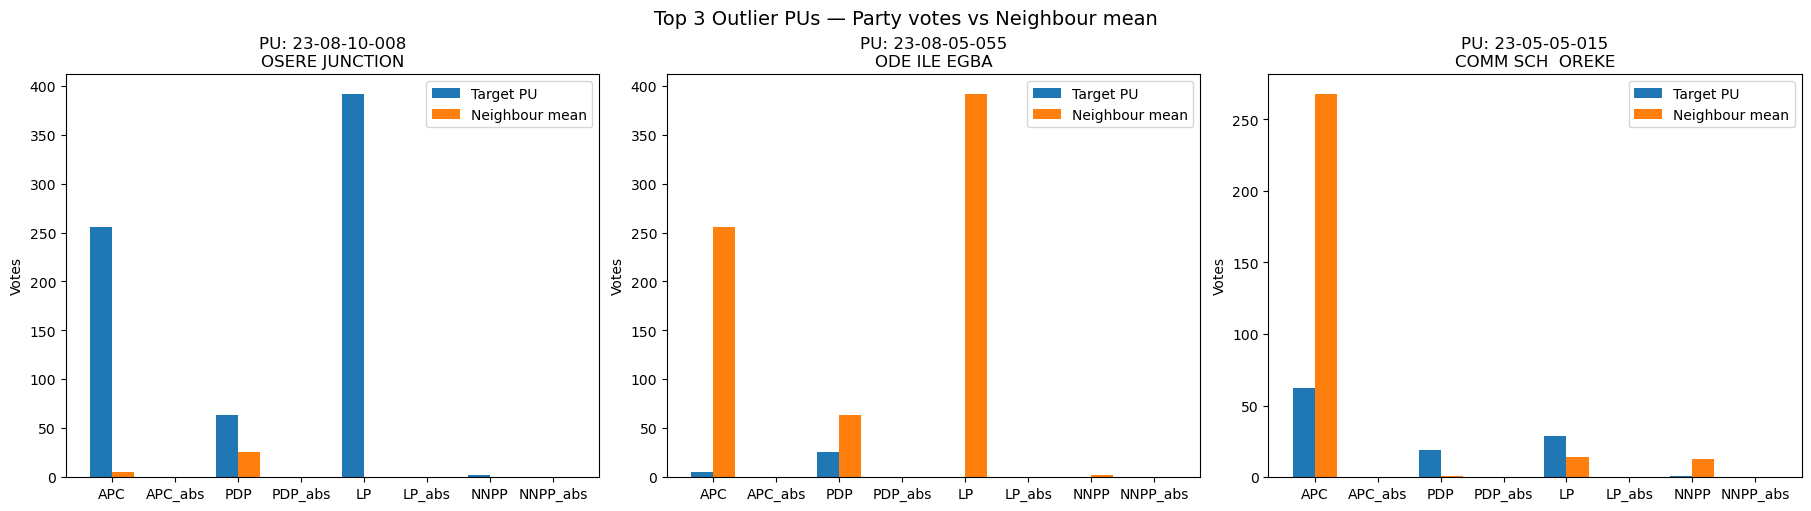

In [20]:
# Top 3 PUs by overall score
top3 = df.sort_values('max_abs_z_1km', ascending=False).head(3).reset_index(drop=True)

# Plot: one grouped bar subplot per PU
fig, axes = plt.subplots(1, 3, figsize=(18,5), constrained_layout=True)
for ax_idx, (idx, row) in enumerate(top3.iterrows()):
    ax = axes[ax_idx]
    parties = party_cols
    target_vals = [row.get(p, 0) for p in parties]
    neigh_means = [row.get(f'{p}_neigh_mean_1km', 0) for p in parties]
    x = np.arange(len(parties))
    width = 0.35
    ax.bar(x - width/2, target_vals, width, label='Target PU')
    ax.bar(x + width/2, neigh_means, width, label='Neighbour mean')
    ax.set_xticks(x)
    ax.set_xticklabels(parties)
    pu_code = row.get('PU-Code', str(idx))
    pu_name = row.get('PU-Name','')
    ax.set_title(f'PU: {pu_code}\n{pu_name}')
    ax.set_ylabel('Votes')
    ax.legend()
    
fname = os.path.join(PLOTS_DIR, 'grouped_bar_top3.png')
plt.suptitle('Top 3 Outlier PUs — Party votes vs Neighbour mean', fontsize=14)
plt.savefig(fname, dpi=150, bbox_inches='tight')
plt.show()



In [21]:
# Draft observation you can paste into your report:
for i, r in top3.iterrows():
    top_party = max(party_cols, key=lambda p: (r.get(p,0)))
    print(f"PU {r.get('PU-Code')} ({r.get('PU-Name')}): highest absolute outlier score = {r.get('max_abs_z_1km')}. The largest vote block is {top_party} (votes={r.get(top_party)}), which differs strongly from neighbour means shown in the chart.")

PU 23-08-10-008 (OSERE JUNCTION): highest absolute outlier score = 392.0. The largest vote block is LP (votes=392), which differs strongly from neighbour means shown in the chart.
PU 23-08-05-055 (ODE ILE EGBA): highest absolute outlier score = 392.0. The largest vote block is PDP (votes=26), which differs strongly from neighbour means shown in the chart.
PU 23-05-05-015 (COMM SCH  OREKE): highest absolute outlier score = 206.0. The largest vote block is APC (votes=62), which differs strongly from neighbour means shown in the chart.


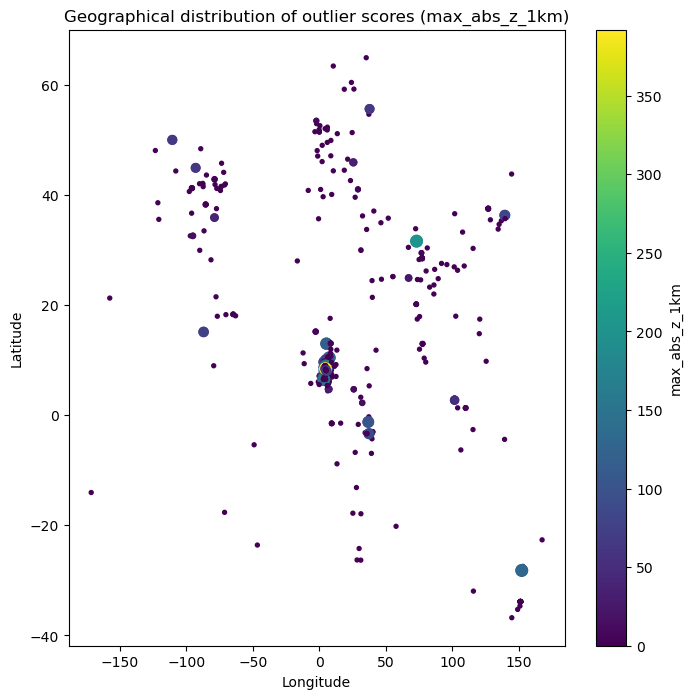

Observation: Median overall outlier score = 1.17. The map shows a few geographically clustered high-score PUs; these clusters should be prioritized for manual checks.


In [22]:
df = pd.read_csv(ENRICHED_CSV)
# ensure numeric
df['max_abs_z_1km'] = pd.to_numeric(df['max_abs_z_1km'], errors='coerce').fillna(0)

plt.figure(figsize=(8,8))
vals = df['max_abs_z_1km'].values
# size scaled lightly by score so high outliers appear larger
sizes = 8 + (np.clip(vals, 0, np.percentile(vals, 99)) / (np.percentile(vals,99) if np.percentile(vals,99)>0 else 1)) * 60
sc = plt.scatter(df['Longitude'], df['Latitude'], s=sizes, c=vals)
plt.colorbar(sc, label='max_abs_z_1km')
plt.xlabel('Longitude'); plt.ylabel('Latitude')
plt.title('Geographical distribution of outlier scores (max_abs_z_1km)')
scatter_path = os.path.join(PLOTS_DIR, 'scatter_outlier_map.png')
plt.savefig(scatter_path, dpi=150, bbox_inches='tight')
plt.show()

# Draft observation for report:
median_score = df['max_abs_z_1km'].median()
print(f"Observation: Median overall outlier score = {median_score:.2f}. The map shows a few geographically clustered high-score PUs; these clusters should be prioritized for manual checks.")

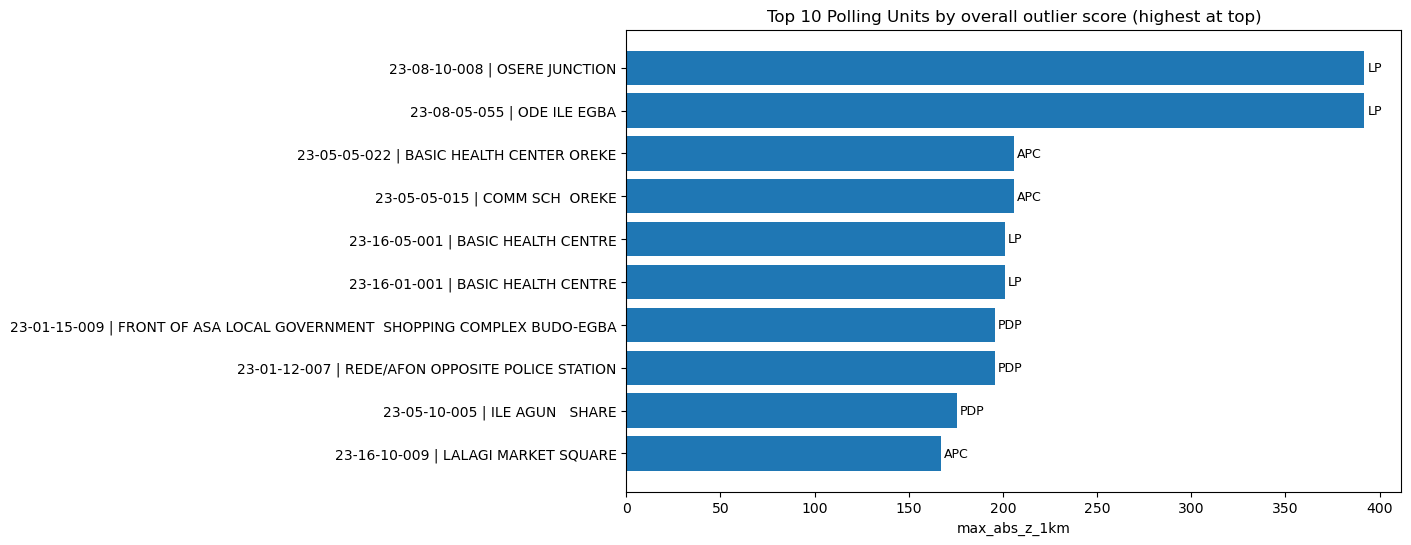

Observation: The horizontal bar chart lists the most extreme PUs and the party responsible for the largest deviation. Use this list as a prioritized checklist for verification (start with the top PU).


In [23]:
df = pd.read_csv(ENRICHED_CSV)
df['max_abs_z_1km'] = pd.to_numeric(df['max_abs_z_1km'], errors='coerce').fillna(0)

top10 = df.sort_values('max_abs_z_1km', ascending=False).head(10).copy()
# identify which party produced the highest absolute z-score for each PU
party_zcols = [c for c in df.columns if c.endswith('_abs_zscore_1km')]
def top_party_for_row(r):
    vals = {p.replace('_abs_zscore_1km',''): r[p] for p in party_zcols if p in r.index}
    if not vals:
        return ''
    return max(vals.items(), key=lambda x: (0 if pd.isna(x[1]) else x[1]))[0]

top10['top_party'] = top10.apply(top_party_for_row, axis=1)
y = np.arange(len(top10))
plt.figure(figsize=(10,6))
plt.barh(y, top10['max_abs_z_1km'][::-1])
plt.yticks(y, (top10['PU-Code'] + ' | ' + top10['PU-Name'])[::-1])
plt.xlabel('max_abs_z_1km')
plt.title('Top 10 Polling Units by overall outlier score (highest at top)')
# annotate with top party
for i, (_, r) in enumerate(top10[::-1].iterrows()):
    plt.text(r['max_abs_z_1km'] + 1.5, i, str(r['top_party']), va='center', fontsize=9)

fname = os.path.join(PLOTS_DIR, 'top10_outlier_barh.png')
plt.savefig(fname, dpi=150, bbox_inches='tight')
plt.show()

# Draft observation for report:
print("Observation: The horizontal bar chart lists the most extreme PUs and the party responsible for the largest deviation. Use this list as a prioritized checklist for verification (start with the top PU).")

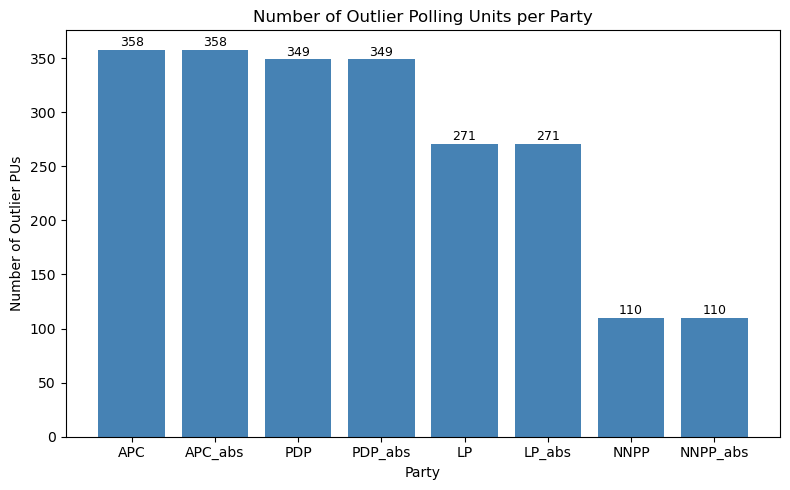

Chart saved to: C:\Kwara_State_Project\plots\outlier_count_per_party.png


,Party,Outlier_Count
0,APC,358
1,APC_abs,358
2,PDP,349
3,PDP_abs,349
4,LP,271
5,LP_abs,271
6,NNPP,110
7,NNPP_abs,110


In [24]:
# Load data
df = pd.read_csv(ENRICHED_CSV)

# Identify per-party z-score columns
party_zcols = [c for c in df.columns if c.endswith('_zscore_1km')]

# Set z-score threshold for "outlier" (you can adjust to 3.0 if you want stricter)
THRESHOLD = 2.5

outlier_counts = {}
for col in party_zcols:
    party = col.replace('_zscore_1km', '')
    zvals = df[col].abs()  # use absolute value
    count = (zvals > THRESHOLD).sum()
    outlier_counts[party] = count

# Convert to DataFrame for plotting
outlier_df = pd.DataFrame(list(outlier_counts.items()), columns=['Party', 'Outlier_Count'])
outlier_df = outlier_df.sort_values('Outlier_Count', ascending=False)

# Plot bar chart
plt.figure(figsize=(8,5))
bars = plt.bar(outlier_df['Party'], outlier_df['Outlier_Count'], color='steelblue')
plt.title(f'Number of Outlier Polling Units per Party')
plt.xlabel('Party')
plt.ylabel('Number of Outlier PUs')

# Add count labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.5, str(int(height)), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
fname = os.path.join(PLOTS_DIR, 'outlier_count_per_party.png')
plt.savefig(fname, dpi=150, bbox_inches='tight')
plt.show()

print("Chart saved to:", fname)
outlier_df

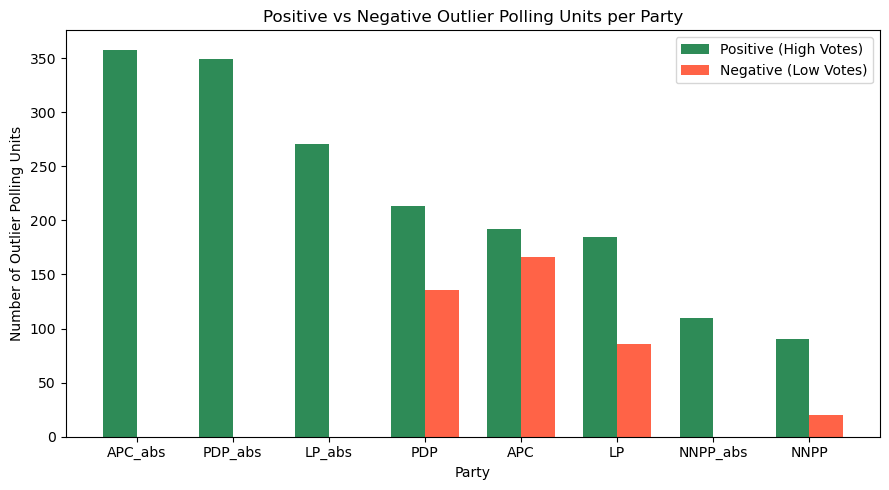

Chart saved to: C:\Kwara_State_Project\plots\outlier_positive_negative_per_party.png


,Party,Positive_Outliers,Negative_Outliers
1,APC_abs,358,0
3,PDP_abs,349,0
5,LP_abs,271,0
2,PDP,213,136
0,APC,192,166
4,LP,185,86
7,NNPP_abs,110,0
6,NNPP,90,20


In [25]:
# Load data
df = pd.read_csv(ENRICHED_CSV)

# Identify z-score columns per party
party_zcols = [c for c in df.columns if c.endswith('_zscore_1km')]

# Threshold for outlier detection
THRESHOLD = 2.5

outlier_counts = []
for col in party_zcols:
    party = col.replace('_zscore_1km', '')
    zvals = df[col]
    pos_count = (zvals > THRESHOLD).sum()    # unusually high votes
    neg_count = (zvals < -THRESHOLD).sum()   # unusually low votes
    outlier_counts.append({'Party': party, 'Positive_Outliers': pos_count, 'Negative_Outliers': neg_count})

outlier_df = pd.DataFrame(outlier_counts)
outlier_df = outlier_df.sort_values('Positive_Outliers', ascending=False)

# Plot grouped bar chart
x = np.arange(len(outlier_df))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, outlier_df['Positive_Outliers'], width, label='Positive (High Votes)', color='seagreen')
plt.bar(x + width/2, outlier_df['Negative_Outliers'], width, label='Negative (Low Votes)', color='tomato')

plt.xticks(x, outlier_df['Party'])
plt.xlabel('Party')
plt.ylabel('Number of Outlier Polling Units')
plt.title(f'Positive vs Negative Outlier Polling Units per Party')
plt.legend()
plt.tight_layout()

# Save chart
fname = os.path.join(PLOTS_DIR, 'outlier_positive_negative_per_party.png')
plt.savefig(fname, dpi=150, bbox_inches='tight')
plt.show()

print("Chart saved to:", fname)
outlier_df